## Governing equations for elastic waves

We can model the *interseismic* phase, i.e., strain accumulation between earthquakes, *coseismic phase*, by combining the elastodynamic wave equation with the material's constitutive law.
For a 3D continuum, momentum balance requires that:
\begin{equation}
\rho \frac{\partial^2 u_i}{\partial t^2} = f_i + \sum_j \frac{\partial}{\partial x_j} \sigma_{ij}, \quad i = 1, 2, 3;\quad j = 1, 2, 3 \tag 1
\end{equation}

Here, $u_i$ is the particle displacement, $f_i$ is body force such as gravity, and $\sigma_{ij}$ is the stress tensor.

Assuming a homogenous isotropic elastic medium, we can relate stresses to strains, $\epsilon_{ij}$, as :

\begin{equation}
\sigma_{ij} = \lambda \delta_{ij}\varepsilon_{kk} + 2\mu\varepsilon_{ij}, \tag 2
\end{equation}
where $\lambda$ and $\mu$ are Lamés constants.



Seismic wave propagates at much faster speeds ($\sim$ km/s) such that the effect of body force can be neglected. With this simplification and rewriting equations (1) and (2) in terms of velocity and stresses, we have the following coupled equations in 2D (XZ coordinate system):

\begin{align}
\rho \frac{\partial v_x}{\partial t} &= \frac{\partial \sigma_{xx}}{\partial x} + \frac{\partial \sigma_{xz}}{\partial z} \tag 3 \\
\rho \frac{\partial v_z}{\partial t} &= \frac{\partial \sigma_{zz}}{\partial z} + \frac{\partial \sigma_{xz}}{\partial x} \tag 4 \\
\end{align}

\begin{align}
\frac{\partial \sigma_{xx}}{\partial t} &= (\lambda + 2\mu) \frac{\partial v_x}{\partial x} + \lambda \frac{\partial v_z}{\partial z} \tag 5 \\
\frac{\partial \sigma_{xz}}{\partial t} &= \mu \left(\frac{\partial v_z}{\partial x} + \frac{\partial v_x}{\partial z} \right) \tag 6\\
\frac{\partial \sigma_{zz}}{\partial t} &= \lambda \frac{\partial v_x}{\partial x} + (\lambda + 2\mu) \frac{\partial v_z}{\partial z} \tag 7\\
\end{align}

## Finite difference discretization

Velocity updates:

\begin{align*}
v_x^{t+\Delta t}| _{i,j} &=  v_x^t|_ {i,j} + \frac{\Delta t}{\rho} \left( \frac{\sigma_{xx}^t |_{i+1,j} - \sigma _{xx}^t| _{i-1,j}}{2\Delta x} + \frac{\sigma _{xz}^t | _{i,j+1} - \sigma _{xz}^t | _{i,j-1}}{2\Delta z} \right) \\
v_z^{t+\Delta t}| _{i,j} &= v_z^t|_ {i,j} + \frac{\Delta t}{\rho} \left( \frac{\sigma_{xz}^t |_{i+1,j} - \sigma _{xz}^t| _{i-1,j}}{2\Delta x} + \frac{\sigma _{zz}^t| _{i,j+1} - \sigma_{zz}^t |_{i,j-1}}{2\Delta z} \right)
\end{align*}

Stress updates:

\begin{align*}
\sigma_{xx}^{t+\Delta t} |_{i,j} &= \sigma_{xx}^t|_{i,j} + \Delta t \left( (\lambda+2\mu) \frac{v_x^t |_{i+1,j} - v_x^t|_{i-1,j}}{2\Delta x} + \lambda \frac{v_z^t|_{i,j+1} - v_z^t|_{i,j-1}}{2\Delta z} \right) \\
\sigma_{zz}^{t+\Delta t}|_{i,j} &= \sigma_{zz}^t|_{i,j} + \Delta t \left( \lambda \frac{v_x^t|_{i+1,j} - v_x^t|_{i-1,j}}{2\Delta x} + (\lambda+2\mu) \frac{v_z^t|_{i,j+1} - v_z^t|_{i,j-1}}{2\Delta z} \right) \\
\sigma_{xz}^{t+\Delta t}|_{i,j} &= \sigma_{xz}^t|_{i,j} + \mu \Delta t \left( \frac{v_x^t|_{i,j+1} - v_x^t|_{i,j-1}}{2\Delta z} + \frac{v_z^t|_{i+1,j} - v_z^t|_{i-1,j}}{2\Delta x} \right)
\end{align*}

### Implementation in python

In [ ]:
# Load the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2**128

In [ ]:
## Parameters defining the simulation time
time_0    = 0.0  # Start time
time_end  = 0.1 # End time

# Parameters defining the domain
domain_x, domain_z = 100, 100  # Domain size
dx, dz             = 1, 1 # Grid spacing (in meters)
nx, nz             = int(domain_x / dx), int(domain_z / dz)  # Number of grid points
grid_x, grid_z     = np.meshgrid(np.arange(0, domain_x, dx), np.arange(0, domain_z, dz))

# Elastic parameters defining the material (upper crustal rocks)
mu      = 3.0e10  # Shear modulus (Pa)
lambda_ = 2.0e10  # Lamé's first parameter (Pa)
rho     = 2900.0  # Density (kg/m^3)

In [ ]:
# We need to compute the time step based on the CFL condition
# to ensure stable solution.
vp = np.sqrt((lambda_ + 2*mu)/rho)
cfl_factor = 0.5  # reduce this for more stability
dt = cfl_factor * min(dx, dz) / vp

time = np.arange(time_0, time_end, dt)

In [ ]:
# Define the initial source-time function for the earthquake
# This is the initial force applied at the source point
# Gaussian source function
def gaussian_source(t, peak_time, sigma):
    """
    Gaussian source function
    Parameters:
        t: Current time (s)
        peak_time: Time of rupture or when amplitude reaches maximum
        sigma: Duration of gaussian
    Returns:
        Amplitude at time t
    """
    return np.exp(-0.5 * ((t - peak_time) / sigma)**2)

In [ ]:
# Constant coefficients used in the finite-difference equations
c1 = 1 / (2 * dx)
c2 = 1 / (2 * dz)
c3 = dt * (lambda_ + 2 * mu)
c4 = dt * lambda_
c5 = dt * mu
c6 = dt / rho

In [ ]:
# Source location
source_x, source_z = nx//2, nz//2
src_t0  = 0.05 # (seconds)

# Initialize velocity and stress wavefields to zero everywhere
vx = np.zeros((nx, nz))  # x-velocity component
vz = np.zeros((nx, nz))  # z-velocity component
sxx = np.zeros((nx, nz))  # normal stress xx
szz = np.zeros((nx, nz))  # normal stress zz
sxz = np.zeros((nx, nz))  # shear stress xz

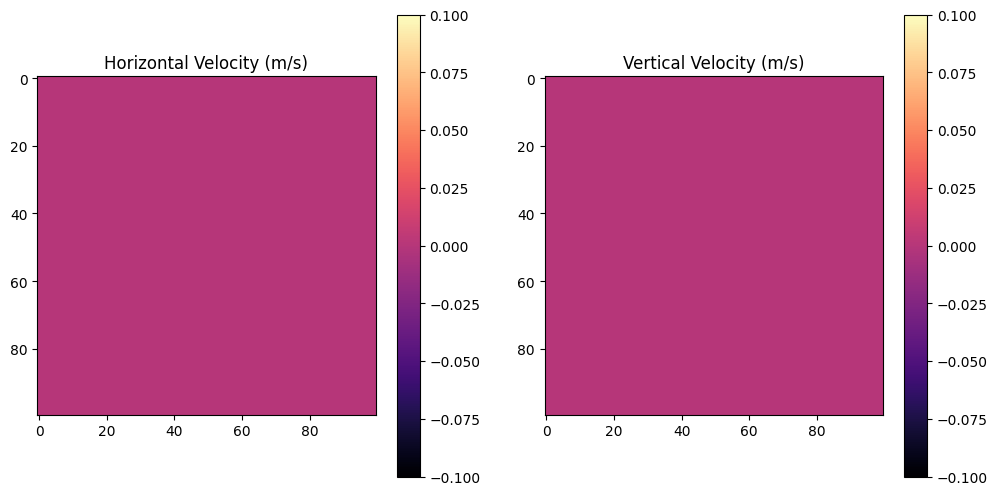

In [ ]:
# Create an initial figure for visualization
# which will be updated in the function animate.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
im1 = ax1.imshow(vx, cmap='magma', interpolation='bilinear')
im2 = ax2.imshow(vz, cmap='magma', interpolation='bilinear')
ax1.set_title('Horizontal Velocity (m/s)')
ax2.set_title('Vertical Velocity (m/s)')
plt.colorbar(im1, ax=ax1)
plt.colorbar(im2, ax=ax2)

def animate(time_step):
    '''
    This function takes the time step, updates the velocity and stress fields,
    and plots it on the figure.

    Inputs:
    time_step (int)       : The time step number in the solution
    '''

    # The following indexing is used to extract the interior of domain
    # except for the boundaries.
    i = slice(1, -1)  # x-direction
    j = slice(1, -1)  # z-direction

    # Compute spatial derivatives of velocities
    dvx_dx = (vx[2:, j] - vx[:-2, j]) * c1
    dvz_dz = (vz[i, 2:] - vz[i, :-2]) * c2
    dvx_dz = (vx[i, 2:] - vx[i, :-2]) * c2
    dvz_dx = (vz[2:, j] - vz[:-2, j]) * c1

    # Update stresses with time
    sxx[i, j] += c3 * dvx_dx + c4 * dvz_dz
    szz[i, j] += c4 * dvx_dx + c3 * dvz_dz
    sxz[i, j] += c5 * (dvx_dz + dvz_dx)

     # Compute spatial derivatives of stresses
    dsxx_dx = (sxx[2:, j] - sxx[:-2, j]) * c6
    dsxz_dz = (sxz[i, 2:] - sxz[i, :-2]) * c6
    dsxz_dx = (sxz[2:, j] - sxz[:-2, j]) * c6
    dszz_dz = (szz[i, 2:] - szz[i, :-2]) * c6

    # Update velocities
    vx[i, j] += dsxx_dx * c1 + dsxz_dz * c2
    vz[i, j] += dsxz_dx * c1 + dszz_dz * c2

    # Apply source (force in x-direction)
    t = dt* time_step
    src_val = 1e8 * gaussian_source(t, 0.1, src_t0)
    vx[source_x, source_z] += src_val * dt / rho

    # Apply absorbing boundary conditions for both wavefields
    # Even if we skip this step, it is okay because we
    # are initializing the arrays to zeros and only filling
    # the interior of the domain.
    for arr in [vx, vz, sxx, szz, sxz]:
        arr[0, :] = 0  # Left boundary
        arr[-1, :] = 0  # Right boundary
        arr[:, 0] = 0  # Top boundary
        arr[:, -1] = 0  # Bottom boundary

    # Update plots
    im1.set_array(vx.T)
    im2.set_array(vz.T)
    return im1, im2

The animation below shows the progression of seismic wave energy with time in a homogeneous medium. The seismic source is in the center of the domain.

Since the source is initiated by velocity perturbation along the X-direction, the horizontal velocity represents the P-wave motion with alternating compression and tension radiating outwards, whereas the vertical velocity represents the secondary perpendicular motion of the S-wave particles.

The resultant velocities is expected and can be compared to another numerical simulation shown in Fig. 7 of [Toomey and Bean, 2000](https://doi.org/10.1046/j.1365-246x.2000.00094.x).


In [ ]:
# Create animation
ani = FuncAnimation(fig, animate, frames=len(time)//10, interval=20, blit=True)
plt.tight_layout()
plt.show()
HTML(ani.to_jshtml())

Output hidden; open in https://colab.research.google.com to view.

### Further Reading

This was a very simple demonstration of elastic wave propagation in an elastic medium. In reality, there are several complexities associated with earthquake generation and wave propagation, including but not limited to:

* medium anisotropy
* medium heterogeneity
* complex source function

Open-source wave propagaion codes such as [SPECFEM](https://github.com/SPECFEM/specfem3d) and [SW4](https://github.com/geodynamics/sw4) can be used to model these complexities.

### References
* Lecture notes by Robert L. Nowack for Introduction to Seismology (course [EAS 557](https://web.ics.purdue.edu/~nowack/geos557/lecture9-dir/lecture9.htm)) Purdue University.
* Manual documentation of [fdfault](https://github.com/edaub/fdfault)
* Kanamori, Hiroo, and Emily E. Brodsky. "The physics of earthquakes." Physics today 54.6 (2001): [34-40](https://www.physik.uni-bielefeld.de/~reimann/PROSEMINAR_SS23/earthquakes.pdf).
* Toomey, A., & Bean, C. J. (2000). Numerical simulation of seismic waves using a discrete particle scheme. Geophysical Journal International, 141(3), [595-604](Numerical simulation of seismic waves using a discrete particle scheme).